In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import uci_datasets

In [5]:

# Directory containing the CSV files
directory = '.'

# Initialize an empty list to store DataFrames
dfs = []

datasets = [name for name, (n_observations, n_dimensions) in uci_datasets.all_datasets.items() if 1 < n_observations < 50000]

# Iterate over the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv') and 'split' in filename:
        global_entries = eval(filename.split('.csv')[0])
        if global_entries['dataset'] not in datasets:
            continue
        # Read the CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        try:
            df = pd.read_csv(filepath)
        except:
            print(f"Error reading file: {filename}")
            continue
        if len(df) < 100:
            continue
            
        # Calculate sliding average for specified fields
        sliding_average_window = 200  # Specify the window size for the sliding average

        # Apply sliding average to the fields
        fields_to_average = ["Train Loss", "Train MSE", "Test MSE", "Layer 0 Smooth Rank", "Layer 1 Smooth Rank", "Layer 2 Smooth Rank"]
        #df[fields_to_average] = df[fields_to_average].rolling(sliding_average_window, min_periods=1).mean()

        # Add columns for dataset
        for k, v in global_entries.items():
            df[k] = v
            
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
big_df = pd.concat(dfs, ignore_index=True)
group_by_keys = [k for k in global_entries.keys() if k != 'split'] + ["Epoch"]
grouped_df = big_df.groupby(group_by_keys).agg(['mean', 'std']).reset_index()

print(big_df.to_markdown())

|       |   Epoch |   Train loss |   Learning rate |   Train MSE |   Test MSE |   logdet |    sigma | dataset   |   split |   optimize_logdet | kernel   |
|------:|--------:|-------------:|----------------:|------------:|-----------:|---------:|---------:|:----------|--------:|------------------:|:---------|
|     0 |       1 |  8.17373     |          0.01   | 0.0165586   |  0.355027  | -2.09967 | 0.1      | energy    |       4 |                 0 | rbf      |
|     1 |       2 |  7.70286     |          0.01   | 0.0226509   |  0.284972  | -2.3628  | 0.1      | energy    |       4 |                 0 | rbf      |
|     2 |       3 |  6.64162     |          0.01   | 0.0236533   |  0.225612  | -2.53664 | 0.1      | energy    |       4 |                 0 | rbf      |
|     3 |       4 |  5.73703     |          0.01   | 0.0228594   |  0.212372  | -2.61438 | 0.1      | energy    |       4 |                 0 | rbf      |
|     4 |       5 |  5.09868     |          0.01   | 0.022976    |  0.

In [6]:

def compute_winners(df, metric):
    df = grouped_df[(grouped_df['Epoch']==100) & (grouped_df['optimize_sigma']==1)][[('dataset', ''), ('start_layer', ''), ('optimize_sigma', ''), (metric, 'mean')]]
    multi_indexed = df.groupby(['dataset',  'start_layer', 'optimize_sigma']).mean()
    winners = multi_indexed.groupby(level=0).idxmin()
    winner_counts = winners[(metric, 'mean')].apply(lambda x: x[1:3]).value_counts()  
    return winner_counts

metric = 'Test MSE'
df = grouped_df[(grouped_df['Epoch']==499) 
                & (grouped_df['optimize_sigma']==0)
                & (grouped_df['start_layer']<=3)
                & (grouped_df['start_layer']>=2)][[('dataset', ''), ('start_layer', ''), ('optimize_sigma', ''), (metric, 'mean')]]

print(df)
print(metric)
print(compute_winners(df, metric))

#metric = 'Train Loss'
#print(metric)
#print(compute_winners(df, metric))

KeyError: 'optimize_sigma'

/tmp/ipykernel_9721/521368601.py:20: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.tight_layout()


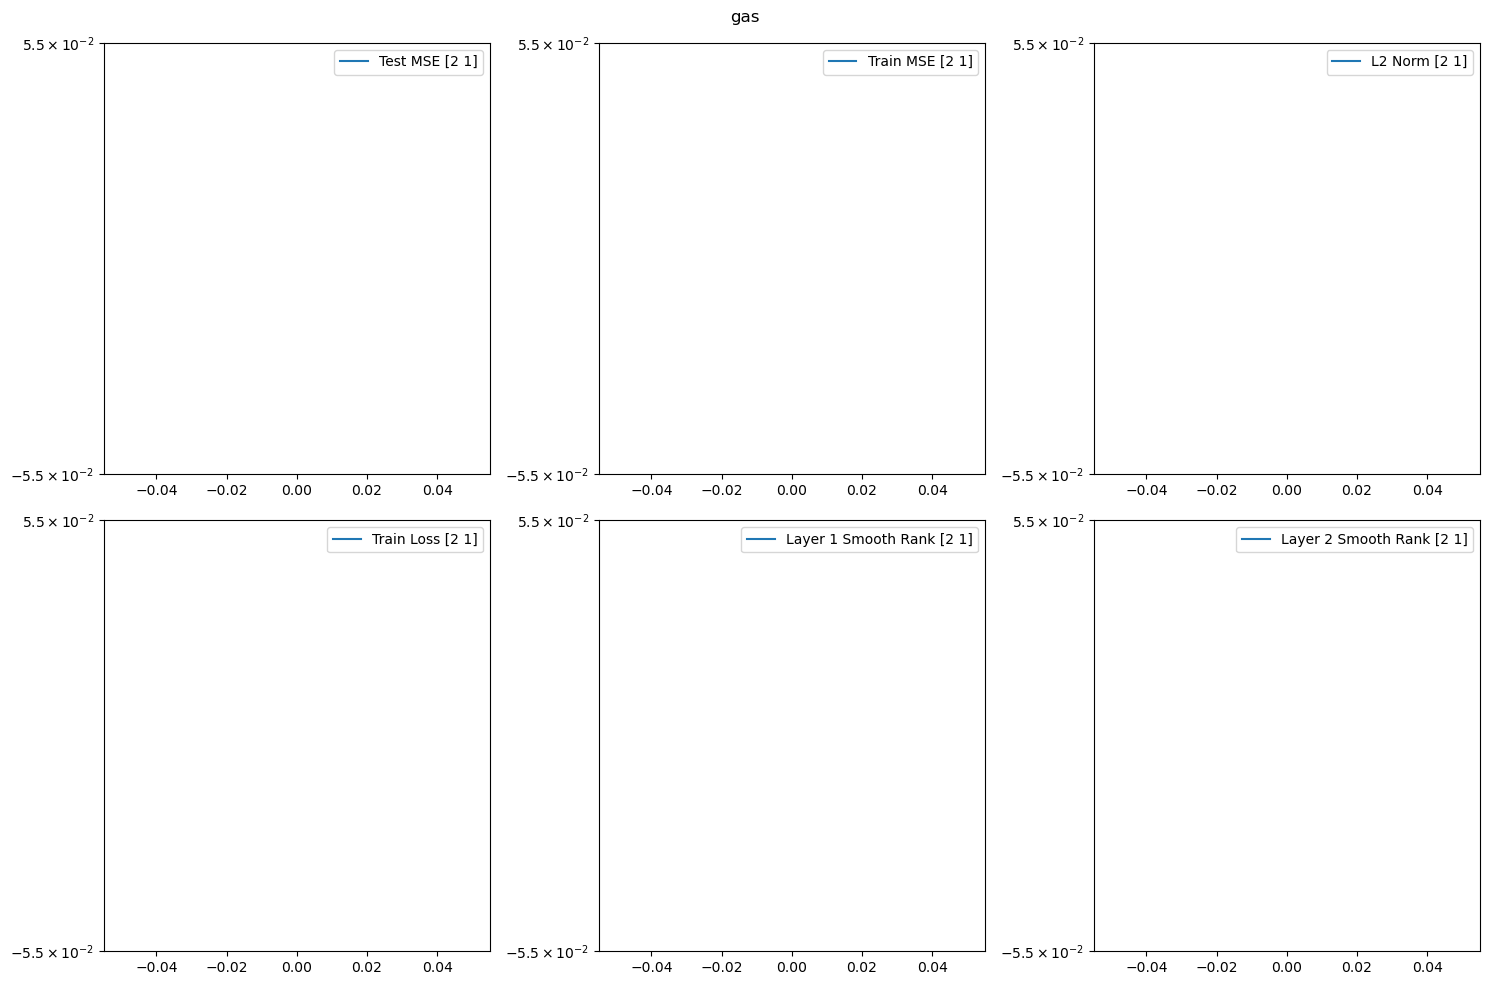

In [ ]:
for dataset in grouped_df['dataset'].unique():
    fig, axs = plt.subplots(2, 3, figsize=(15,10))  # create 6 subplots, 2 rows by 3 columns
    fig.suptitle(dataset)
    for start_layer in grouped_df['start_layer'].unique():
        for optimize_sigma in [1]:
            df = grouped_df[(grouped_df.dataset == dataset) 
                            & (grouped_df.start_layer == start_layer)
                            #& (grouped_df.optimize_sigma == optimize_sigma)
                            & (grouped_df.Epoch >= 100)]

            # For each subplot, plot the mean values and fill between the (mean - std) and (mean + std) values
            for i, metric in enumerate(['Test MSE', 'Train MSE', 'L2 Norm', 'Train Loss', 'Layer 1 Smooth Rank', 'Layer 2 Smooth Rank']):
                mean = df[(metric, 'mean')]
                std = df[(metric, 'std')]
                axs[i // 3, i % 3].plot(df['Epoch'], mean, label=f'{metric} [{start_layer} {optimize_sigma}]')
                axs[i // 3, i % 3].fill_between(df['Epoch'], mean - std, mean + std, alpha=0.1)
                axs[i // 3, i % 3].set_yscale('symlog')
                axs[i // 3, i % 3].legend()

plt.tight_layout()
plt.show()
